#Imports and Initializations

In [1]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import Sequence
from tensorflow import keras
from google.colab import drive
import tensorflow as tf
import tensorflow.keras.metrics as metrics
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import load_img
from skimage.metrics import structural_similarity
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

drive.mount('/content/gdrive')
# FOLDER_PATH = '/kaggle/input/imdb-face-dataset/Face_Final_Dataset/'
FOLDER_PATH = 'Face_Final_Dataset/'

Found GPU at: /device:GPU:0
Mounted at /content/gdrive


#Unzip the dataset

In [2]:
!unzip /content/gdrive/MyDrive/CS512/Project/Face_Final_Dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: Face_Final_Dataset/Speckle/nm1798644_rm2637205248_1964-1-4_2000.jpg  
 extracting: Face_Final_Dataset/Speckle/nm1798644_rm3981610752_1964-1-4_2000.jpg  
 extracting: Face_Final_Dataset/Speckle/nm1798644_rm929861376_1964-1-4_2000.jpg  
 extracting: Face_Final_Dataset/Speckle/nm1799038_rm645832960_1978-1-1_2013.jpg  
 extracting: Face_Final_Dataset/Speckle/nm1799073_rm1389408768_1917-11-7_1975.jpg  
 extracting: Face_Final_Dataset/Speckle/nm1799073_rm1573958144_1917-11-7_1975.jpg  
 extracting: Face_Final_Dataset/Speckle/nm1799073_rm1607512576_1917-11-7_1975.jpg  
 extracting: Face_Final_Dataset/Speckle/nm1799783_rm1609665536_1965-5-3_2010.jpg  
 extracting: Face_Final_Dataset/Speckle/nm1799783_rm3105330944_1965-5-3_2004.jpg  
 extracting: Face_Final_Dataset/Speckle/nm1800670_rm1156751872_1984-3-26_2012.jpg  
 extracting: Face_Final_Dataset/Speckle/nm1800670_rm1207083520_1984-3-26_2012.jpg  
 extracting: Face_Final_Dataset/S

#Defined all the utility functions like generators, train, validation and test sets

In [3]:
class DataLoader(Sequence):
    # data generator for loading pairs of noisy and clean images from a given list of image paths and a given batch size / image size
    def __init__(self, batch_size, image_size, images_path):
        self.images_path = images_path
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return len(self.images_path) // self.batch_size

    def __getitem__(self, idx, dt = "float32"):
        c = idx * self.batch_size
        input_image_paths = self.images_path[c:c+self.batch_size]
        noise = np.zeros((self.batch_size,) + self.image_size + (1,), dtype=dt)
        original = np.zeros((self.batch_size,) + self.image_size + (1,), dtype=dt)
        
        for i in range(len(input_image_paths)):
            noise[i] = np.expand_dims(load_img(input_image_paths[i][0], target_size=self.image_size, color_mode="grayscale"), 2) / 255.
            original[i] = np.expand_dims(load_img(input_image_paths[i][1], target_size=self.image_size, color_mode="grayscale"), 2) / 255.

        return noise, original

In [4]:
def load_data_files():
    # reading data paths from the base directory
    image_paths = sorted(os.listdir(FOLDER_PATH + 'Face_Dataset'))
    all_pairs = []
    for im in image_paths:
        org_img = FOLDER_PATH + 'Face_Dataset/' + im
        for flrd in ['Gaussian/', 'Impulse/', 'Poisson/', 'Speckle/']:
            noisy_img = FOLDER_PATH + flrd + im
            all_pairs.append((noisy_img, org_img))
    return all_pairs

def get_dataset_splits(all_images):
    # perform training, testing and validation splits
    total = len(all_images)
    train_split = total*4 // 5
    random.Random(1234).shuffle(all_images)
    training = all_images[:train_split]
    testing = all_images[train_split:]
    valid_split = len(training) // 10
    random.Random(1234).shuffle(training)
    validation = training[:valid_split]
    training = training[valid_split:]
    return training, validation, testing

In [5]:
#image_size is 100*100
batch_size = 128
image_size = (100, 100)
all_images = load_data_files()
training, validation, testing = get_dataset_splits(all_images)

In [6]:
len(training), len(validation), len(testing)

(144003, 16000, 40001)

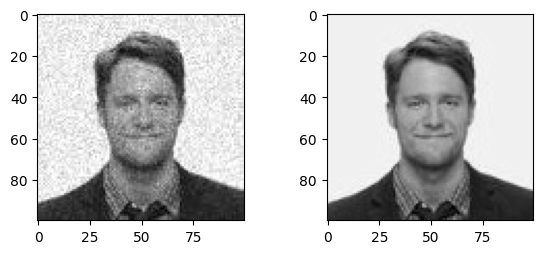

In [7]:
train_gen = DataLoader(batch_size, image_size, training)
valid_gen = DataLoader(batch_size, image_size, validation)
test_gen = DataLoader(batch_size, image_size, testing)
im, ms = train_gen.__getitem__(0)
# visualize to check if the generator is working as expected
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(im[10], cmap="gray")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(ms[10], cmap="gray")
plt.show()

# Visualization functions and custom metrics functions

In [8]:
def display_result(md, i = 20):
    val_preds = md.predict(test_gen)
    img = cv2.imread(testing[i][1],0)
    display([cv2.imread(testing[i][0]), cv2.imread(testing[i][1]), val_preds[i]*255])

def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if display_list[i].shape[-1] == 3:
            plt.imshow(np.flip(display_list[i], axis=-1))
        else:
            plt.imshow(display_list[i], cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
    plt.show()
    
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def visualization(history):
    # Plotting training and validation losses and accuracy against epochs
    plt.plot(history.history['psnr'])
    plt.plot(history.history['val_psnr'])
    plt.title('model psnr')
    plt.ylabel('psnr')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['ssim'])
    plt.plot(history.history['val_ssim'])
    plt.title('model ssim')
    plt.ylabel('ssim')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

#Single autoencoder model definition both with and without separable convolutions

In [ ]:
def single_autoencoder(model, inp_shape=(100, 100, 1)):
    if model == 'SCNN':
        convolution = SeparableConv2D
    elif model == 'CNN':
        convolution = Conv2D
    inputs = Input(shape = inp_shape, name="image")

    conv1 = convolution(filters=50, kernel_size=(3, 3), strides=1, activation='relu')(inputs)
    conv2 = convolution(filters=35, kernel_size=(3, 3), strides=2, activation='relu')(conv1)
    conv3 = convolution(filters=25, kernel_size=(3, 3), strides=2, activation='relu')(conv2)
  
    deconv1 = Conv2DTranspose(filters=25, kernel_size=(3, 3), strides=(2, 2), activation='relu')(conv3)
    deconv2 = Conv2DTranspose(filters=25, kernel_size=(3, 3), strides=(2, 2), activation='relu')(deconv1)
    deconv3 = Conv2DTranspose(filters=1, kernel_size=(6, 6), strides=1, activation='sigmoid')(deconv2)
    model = keras.Model(inputs, deconv3, name="denoising")
    return model

In [ ]:
single_conv_model = single_autoencoder('CNN')
single_conv_model.summary()

Model: "denoising"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 98, 98, 50)        500       
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 35)        15785     
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 23, 25)        7900      
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 47, 47, 25)       5650      
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 95, 95, 25)       5650      
 ranspose)                                               

Epoch 1/40
1125/1125 [==============================] - 314s 277ms/step - loss: 0.5237 - psnr: 21.6044 - ssim: 0.6436 - val_loss: 0.5145 - val_psnr: 23.0444 - val_ssim: 0.7014
Epoch 2/40
1125/1125 [==============================] - 299s 266ms/step - loss: 0.5136 - psnr: 23.5382 - ssim: 0.7290 - val_loss: 0.5117 - val_psnr: 24.0031 - val_ssim: 0.7456
Epoch 3/40
1125/1125 [==============================] - 293s 261ms/step - loss: 0.5116 - psnr: 24.2641 - ssim: 0.7624 - val_loss: 0.5102 - val_psnr: 24.6575 - val_ssim: 0.7750
Epoch 4/40
1125/1125 [==============================] - 297s 264ms/step - loss: 0.5105 - psnr: 24.7270 - ssim: 0.7807 - val_loss: 0.5101 - val_psnr: 24.6494 - val_ssim: 0.7844
Epoch 5/40
1125/1125 [==============================] - 292s 259ms/step - loss: 0.5100 - psnr: 24.9688 - ssim: 0.7878 - val_loss: 0.5091 - val_psnr: 25.1191 - val_ssim: 0.7890
Epoch 6/40
1125/1125 [==============================] - 292s 260ms/step - loss: 0.5095 - psnr: 25.1660 - ssim: 0.7928 - 

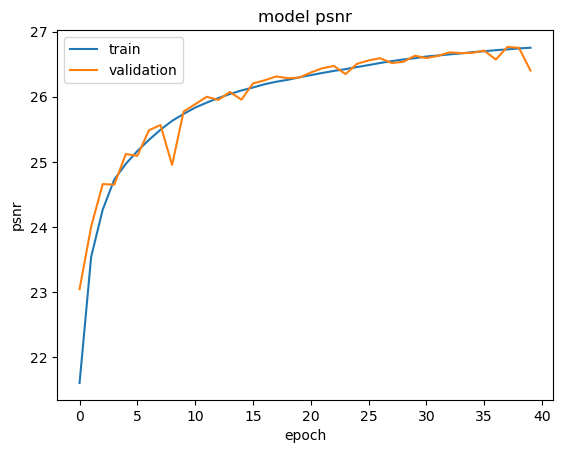

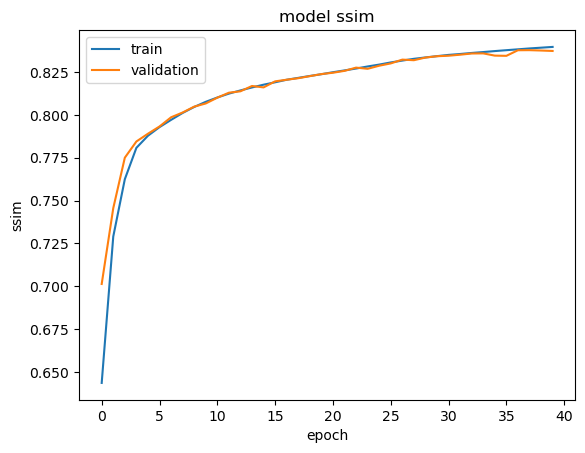

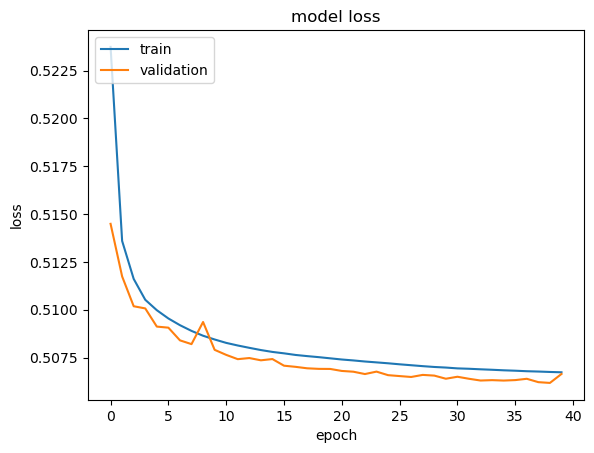

In [ ]:
# Configure the model for training.
# because our target data is integers.
single_conv_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[psnr, ssim])

# Train the model, doing validation at the end of each epoch.
epochs = 40
history = single_conv_model.fit(train_gen, epochs=epochs, validation_data=valid_gen)
visualization(history)

In [ ]:
single_conv_model.save("single_conv_model.h5")

312/312 [==============================] - 302s 970ms/step


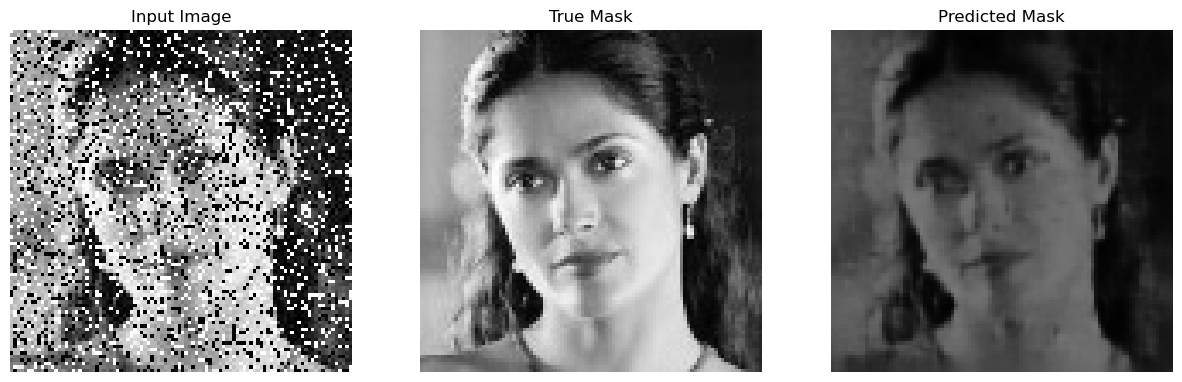

312/312 [==============================] - 74s 237ms/step


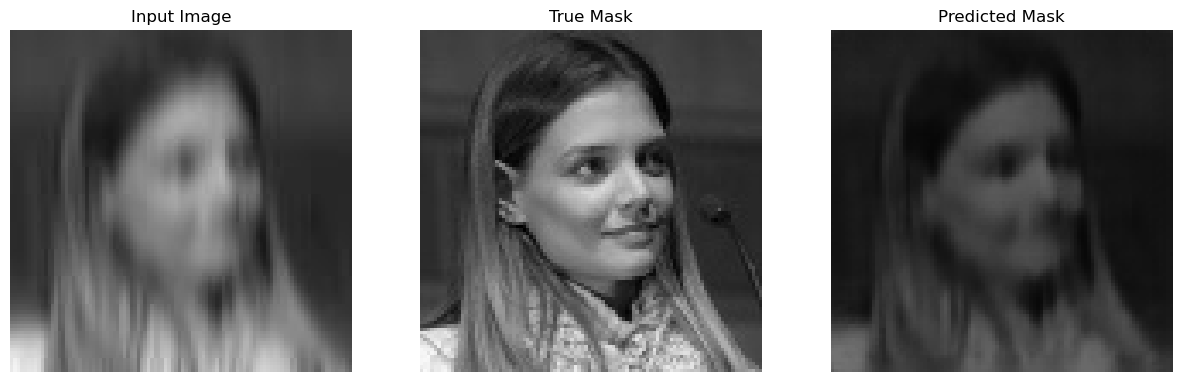

In [ ]:
display_result(single_conv_model, 10)
display_result(single_conv_model, 12)

# Dual autoencoder definition both with and without separable convolutions

In [ ]:
def dual_autoencoder(model, inp_shape=(100, 100, 1)):
    if model == 'SCNN':
        convolution = SeparableConv2D
    elif model == 'CNN':
        convolution = Conv2D
    inputs = Input(shape = inp_shape, name="image")

    conv1 = convolution(filters=50, kernel_size=(3, 3), strides=1, activation='relu')(inputs)
    conv2 = convolution(filters=35, kernel_size=(3, 3), strides=2, activation='relu')(conv1)
    conv3 = convolution(filters=25, kernel_size=(3, 3), strides=2, activation='relu')(conv2)

    deconv1 = Conv2DTranspose(filters=25, kernel_size=(3, 3), strides=(2, 2), activation='relu')(conv3)
    deconv2 = Conv2DTranspose(filters=25, kernel_size=(3, 3), strides=(2, 2), activation='relu')(deconv1)
    deconv3 = Conv2DTranspose(filters=1, kernel_size=(6, 6), strides=(1, 1), activation='relu')(deconv2)

    conv4 = convolution(filters=25, kernel_size=(3, 3), strides=1, activation='relu')(deconv3)
    conv5 = convolution(filters=25, kernel_size=(3, 3), strides=1, activation='relu')(conv4)
    conv6 = convolution(filters=50, kernel_size=(3, 3), strides=2, activation='relu')(conv5)

    deconv4 = Conv2DTranspose(filters=50, kernel_size=(3, 3), strides=(2, 2), activation='relu')(conv6)
    deconv5 = Conv2DTranspose(filters=25, kernel_size=(3, 3), strides=(1, 1), activation='relu')(deconv4)
    deconv6 = Conv2DTranspose(filters=1, kernel_size=(4, 4), strides=(1, 1), activation='sigmoid')(deconv5)

    model = tf.keras.Model(inputs, deconv6, name="denoising")
    return model

In [ ]:
dual_conv_model = dual_autoencoder('CNN')
dual_conv_model.summary()

Model: "denoising"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 98, 98, 50)        500       
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 35)        15785     
                                                                 
 conv2d_8 (Conv2D)           (None, 23, 23, 25)        7900      
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 47, 47, 25)       5650      
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 95, 95, 25)       5650      
 ranspose)                                               

Epoch 1/40
1125/1125 [==============================] - 323s 283ms/step - loss: 0.5416 - psnr: 20.7791 - ssim: 0.6060 - val_loss: 0.5141 - val_psnr: 23.2694 - val_ssim: 0.7177
Epoch 2/40
1125/1125 [==============================] - 314s 279ms/step - loss: 0.5192 - psnr: 22.9612 - ssim: 0.7134 - val_loss: 0.5119 - val_psnr: 24.0460 - val_ssim: 0.7500
Epoch 3/40
1125/1125 [==============================] - 307s 272ms/step - loss: 0.5122 - psnr: 24.2097 - ssim: 0.7655 - val_loss: 0.5125 - val_psnr: 23.9840 - val_ssim: 0.7719
Epoch 4/40
1125/1125 [==============================] - 312s 277ms/step - loss: 0.5115 - psnr: 24.5571 - ssim: 0.7813 - val_loss: 0.5099 - val_psnr: 24.9084 - val_ssim: 0.7900
Epoch 5/40
1125/1125 [==============================] - 314s 279ms/step - loss: 0.5122 - psnr: 24.5094 - ssim: 0.7804 - val_loss: 0.5181 - val_psnr: 21.9963 - val_ssim: 0.7633
Epoch 6/40
1125/1125 [==============================] - 314s 279ms/step - loss: 0.5121 - psnr: 24.5398 - ssim: 0.7833 - 

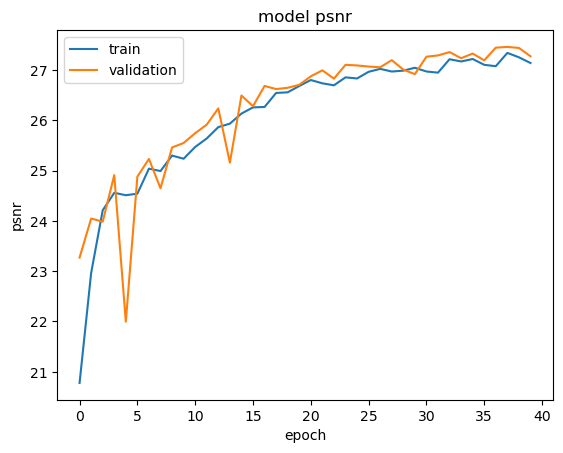

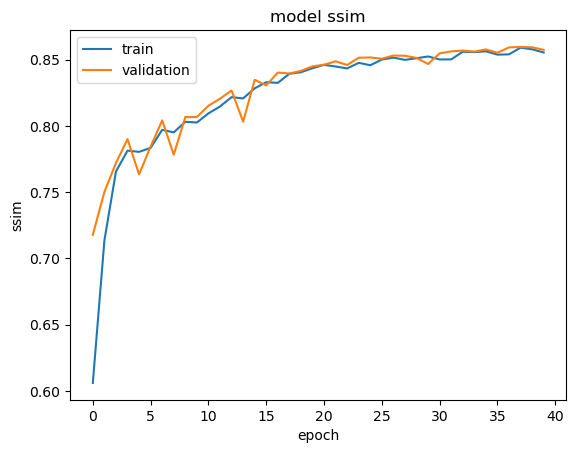

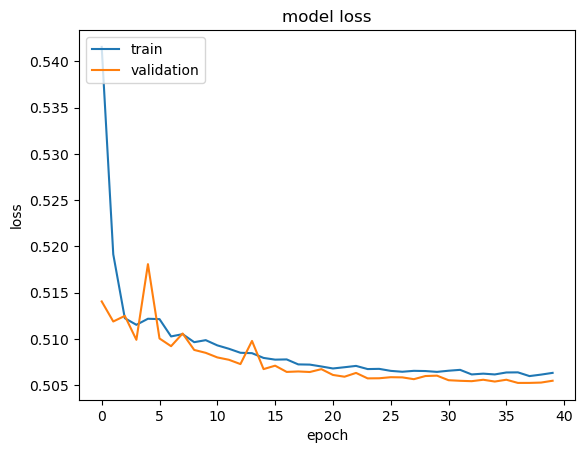

In [ ]:
dual_conv_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[psnr, ssim])

epochs = 40
history = dual_conv_model.fit(train_gen, epochs=epochs, validation_data=valid_gen)
visualization(history)

In [ ]:
dual_conv_model.save("dual_conv_model.h5")

312/312 [==============================] - 105s 337ms/step


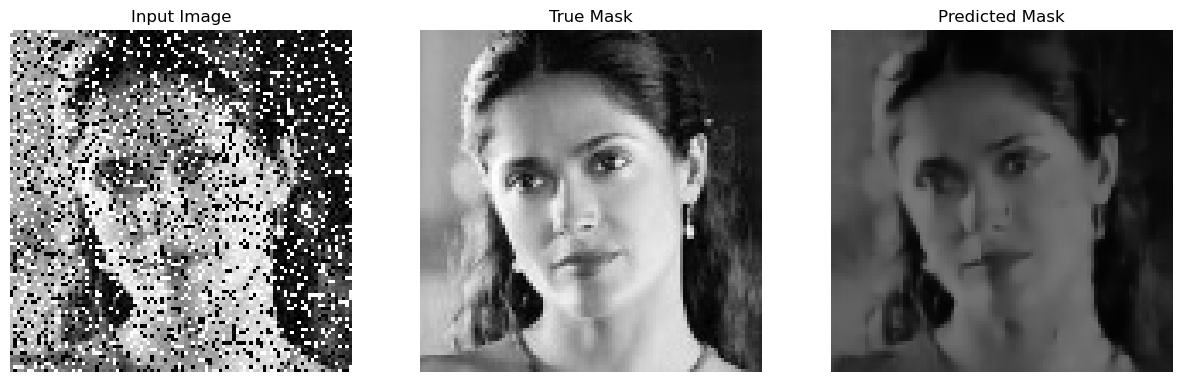

312/312 [==============================] - 68s 219ms/step


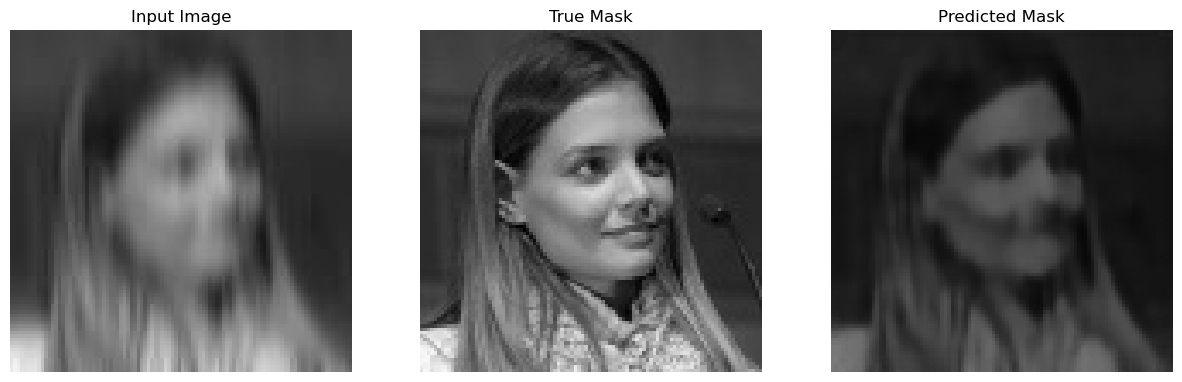

In [ ]:
display_result(dual_conv_model, 10)
display_result(dual_conv_model, 12)

In [ ]:
single_sep_conv_model = single_autoencoder('SCNN')
single_sep_conv_model.summary()

Model: "denoising"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 100, 100, 1)]     0         
                                                                 
 separable_conv2d (Separable  (None, 98, 98, 50)       109       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 48, 48, 35)       2235      
 leConv2D)                                                       
                                                                 
 separable_conv2d_2 (Separab  (None, 23, 23, 25)       1215      
 leConv2D)                                                       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 47, 47, 25)       5650      
 nspose)                                                 

Epoch 1/40
1125/1125 [==============================] - 890s 783ms/step - loss: 0.5298 - psnr: 20.5049 - ssim: 0.5969 - val_loss: 0.5193 - val_psnr: 21.7839 - val_ssim: 0.6438
Epoch 2/40
1125/1125 [==============================] - 298s 265ms/step - loss: 0.5175 - psnr: 22.4154 - ssim: 0.6670 - val_loss: 0.5159 - val_psnr: 22.7056 - val_ssim: 0.6787
Epoch 3/40
1125/1125 [==============================] - 286s 254ms/step - loss: 0.5160 - psnr: 22.8761 - ssim: 0.6870 - val_loss: 0.5150 - val_psnr: 23.0146 - val_ssim: 0.6900
Epoch 4/40
1125/1125 [==============================] - 289s 257ms/step - loss: 0.5152 - psnr: 23.1120 - ssim: 0.6961 - val_loss: 0.5145 - val_psnr: 23.1545 - val_ssim: 0.6988
Epoch 5/40
1125/1125 [==============================] - 286s 254ms/step - loss: 0.5144 - psnr: 23.3581 - ssim: 0.7068 - val_loss: 0.5135 - val_psnr: 23.4995 - val_ssim: 0.7096
Epoch 6/40
1125/1125 [==============================] - 287s 255ms/step - loss: 0.5138 - psnr: 23.5747 - ssim: 0.7161 - 

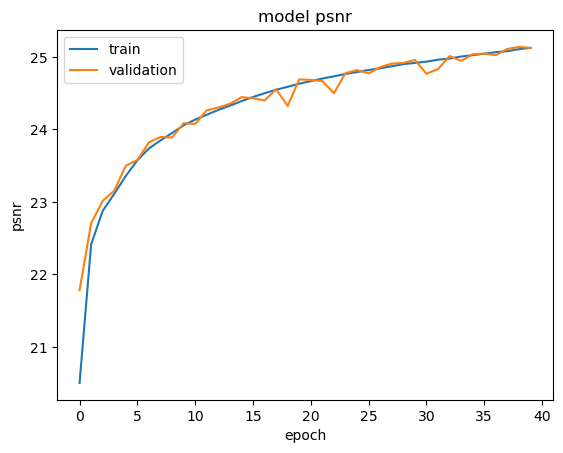

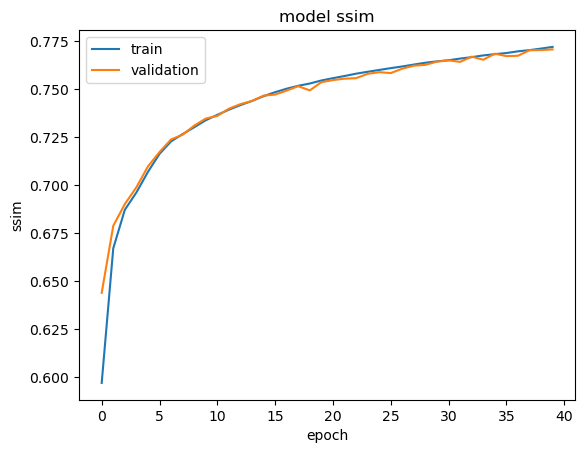

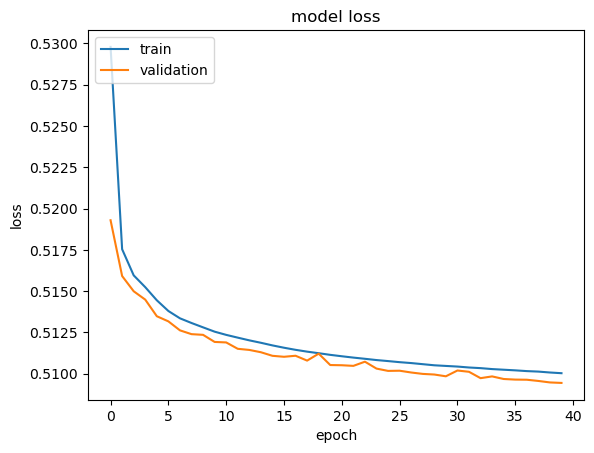

In [ ]:
# Configure the model for training.
# because our target data is integers.
single_sep_conv_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[psnr, ssim])

# Train the model, doing validation at the end of each epoch.
epochs = 40
history = single_sep_conv_model.fit(train_gen, epochs=epochs, validation_data=valid_gen)
visualization(history)

In [ ]:
single_sep_conv_model.save("single_sep_conv_model.h5")

312/312 [==============================] - 276s 887ms/step


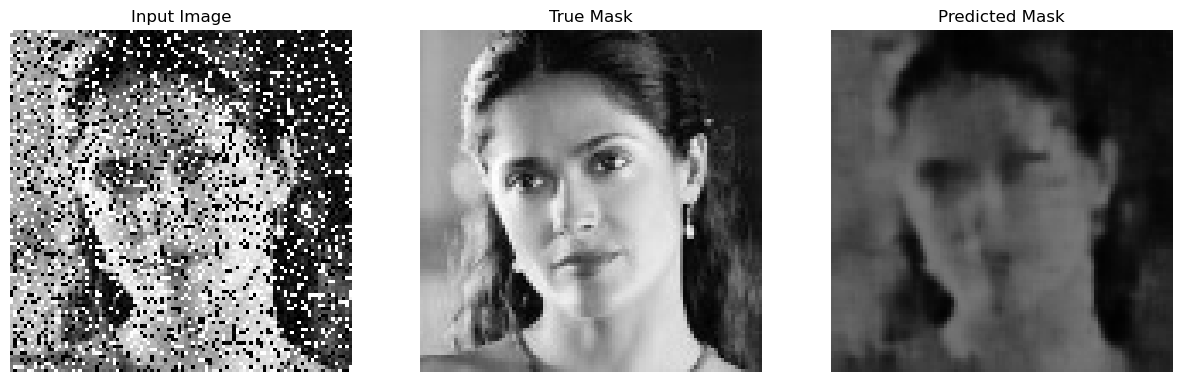

312/312 [==============================] - 73s 234ms/step


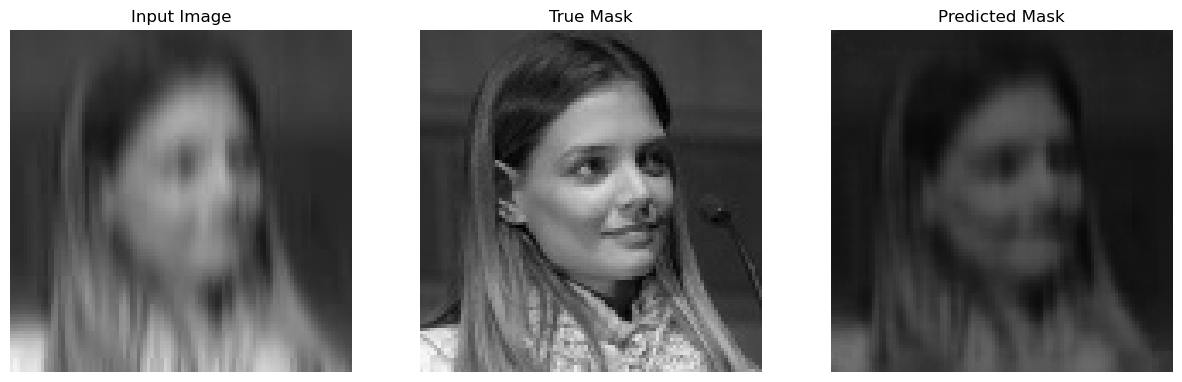

In [ ]:
display_result(single_sep_conv_model, 10)
display_result(single_sep_conv_model, 12)

In [ ]:
dual_sep_conv_model = dual_autoencoder('SCNN')
dual_sep_conv_model.summary()

Model: "denoising"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 100, 100, 1)]     0         
                                                                 
 separable_conv2d_3 (Separab  (None, 98, 98, 50)       109       
 leConv2D)                                                       
                                                                 
 separable_conv2d_4 (Separab  (None, 48, 48, 35)       2235      
 leConv2D)                                                       
                                                                 
 separable_conv2d_5 (Separab  (None, 23, 23, 25)       1215      
 leConv2D)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 47, 47, 25)       5650      
 ranspose)                                               

Epoch 1/40
1125/1125 [==============================] - 305s 266ms/step - loss: 0.5800 - psnr: 18.3115 - ssim: 0.4889 - val_loss: 0.5182 - val_psnr: 22.1107 - val_ssim: 0.6435
Epoch 2/40
1125/1125 [==============================] - 299s 266ms/step - loss: 0.5179 - psnr: 22.3940 - ssim: 0.6628 - val_loss: 0.5153 - val_psnr: 22.9351 - val_ssim: 0.6818
Epoch 3/40
1125/1125 [==============================] - 305s 271ms/step - loss: 0.5163 - psnr: 22.9053 - ssim: 0.6897 - val_loss: 0.5140 - val_psnr: 23.4042 - val_ssim: 0.7039
Epoch 4/40
1125/1125 [==============================] - 299s 266ms/step - loss: 0.5144 - psnr: 23.4850 - ssim: 0.7143 - val_loss: 0.5132 - val_psnr: 23.7013 - val_ssim: 0.7197
Epoch 5/40
1125/1125 [==============================] - 299s 266ms/step - loss: 0.5137 - psnr: 23.7701 - ssim: 0.7280 - val_loss: 0.5137 - val_psnr: 23.5438 - val_ssim: 0.7200
Epoch 6/40
1125/1125 [==============================] - 299s 266ms/step - loss: 0.5136 - psnr: 23.8396 - ssim: 0.7338 - 

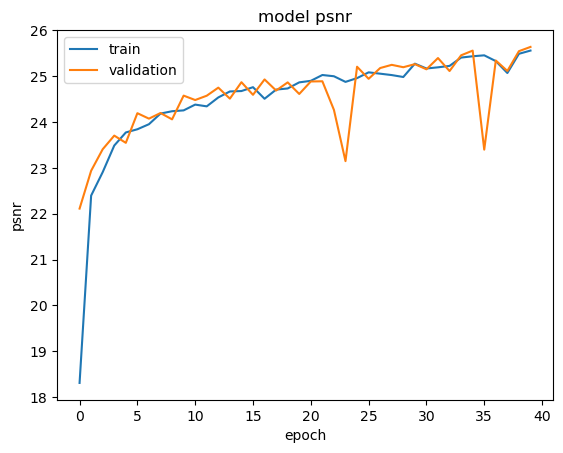

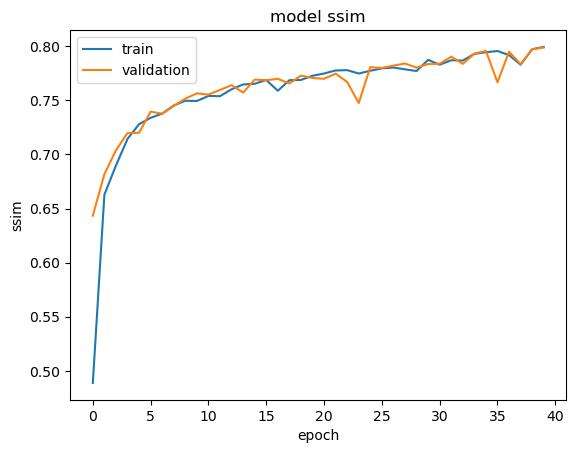

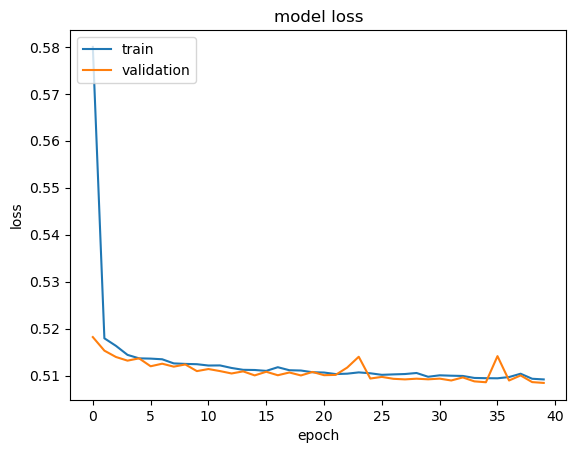

In [ ]:
# Configure the model for training.
# because our target data is integers.
dual_sep_conv_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[psnr, ssim])

# Train the model, doing validation at the end of each epoch.
epochs = 40
history = dual_sep_conv_model.fit(train_gen, epochs=epochs, validation_data=valid_gen)
visualization(history)

In [ ]:
dual_sep_conv_model.save("dual_sep_conv_model.h5")

312/312 [==============================] - 118s 376ms/step


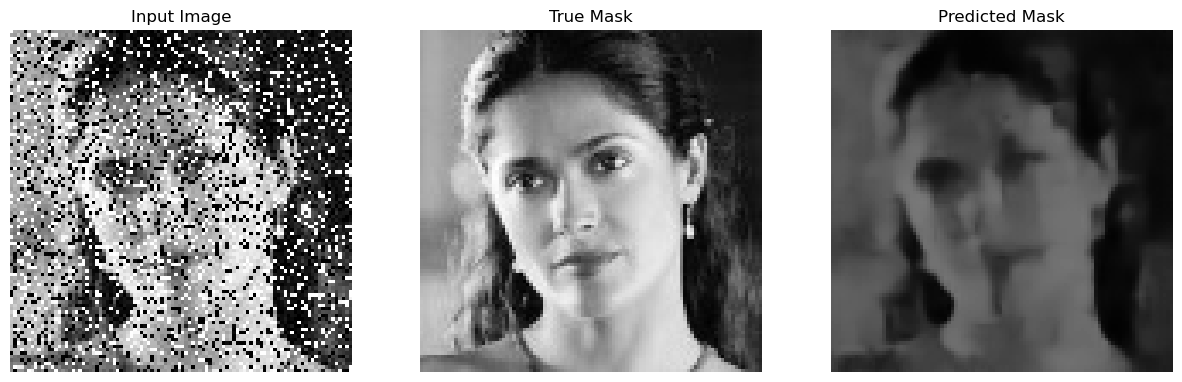

312/312 [==============================] - 70s 226ms/step


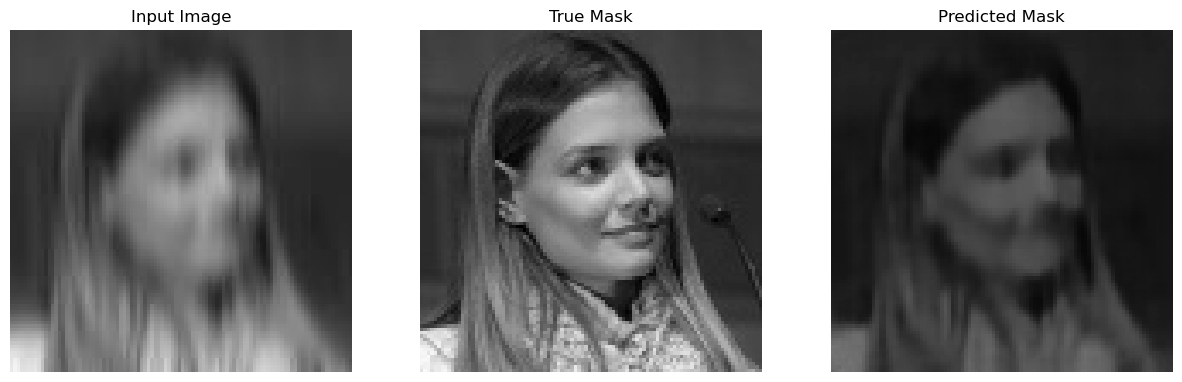

In [ ]:
display_result(dual_sep_conv_model, 10)
display_result(dual_sep_conv_model, 12)

#Dual autoencoder with skip connections definition both with and without separable convolutions

In [ ]:
def dual_autoencoder_with_skip(model, inp_shape=(100, 100, 1)):
    if model == 'SCNN':
        convolution = SeparableConv2D
    elif model == 'CNN':
        convolution = Conv2D
    inputs = Input(shape = inp_shape, name="image")

    conv1 = convolution(filters=50, kernel_size=(3, 3), strides=1, activation='relu')(inputs)
    conv2 = convolution(filters=35, kernel_size=(3, 3), strides=2, activation='relu')(conv1)
    conv3 = convolution(filters=25, kernel_size=(3, 3), strides=2, activation='relu')(conv2)

    deconv1 = Conv2DTranspose(filters=25, kernel_size=(3, 3), strides=(2, 2), activation='relu')(conv3)
    deconv2 = Conv2DTranspose(filters=25, kernel_size=(3, 3), strides=(2, 2), activation='relu')(deconv1)
    deconv3 = Conv2DTranspose(filters=1, kernel_size=(6, 6), strides=(1, 1), activation='relu')(deconv2)

    conv4 = convolution(filters=25, kernel_size=(3, 3), strides=1, activation='relu')(deconv3)
    conv4 = Add()([conv4, convolution(25, 1, activation='relu')(conv1)])
    conv5 = convolution(filters=25, kernel_size=(3, 3), strides=1, activation='relu')(conv4)
    conv5 = Add()([conv5 , UpSampling2D(size=(2,2))(convolution(25, 1, activation='relu')(conv2))])
    conv6 = convolution(filters=50, kernel_size=(3, 3), strides=2, activation='relu')(conv5)
    conv6 = Add()([conv6, Conv2DTranspose(filters=1, kernel_size=(2, 2), strides=(1, 1), activation='relu')(UpSampling2D(size=(2,2))(convolution(50, 1, activation='relu')(conv3)))])

    deconv4 = Conv2DTranspose(filters=50, kernel_size=(3, 3), strides=(2, 2), activation='relu')(conv6)
    deconv5 = Conv2DTranspose(filters=25, kernel_size=(3, 3), strides=(1, 1), activation='relu')(deconv4)
    deconv6 = Conv2DTranspose(filters=1, kernel_size=(4, 4), strides=(1, 1), activation='sigmoid')(deconv5)

    model = tf.keras.Model(inputs, deconv6, name="denoising")
    return model

In [ ]:
dual_with_skip = dual_autoencoder_with_skip('CNN')
dual_with_skip.summary()

Model: "denoising"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 98, 98, 50)   500         ['image[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 48, 35)   15785       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 23, 23, 25)   7900        ['conv2d_1[0][0]']       

Epoch 1/40
1125/1125 [==============================] - 987s 866ms/step - loss: 0.5232 - psnr: 22.7006 - ssim: 0.6869 - val_loss: 0.5108 - val_psnr: 24.5971 - val_ssim: 0.7624
Epoch 2/40
1125/1125 [==============================] - 371s 330ms/step - loss: 0.5118 - psnr: 24.6879 - ssim: 0.7715 - val_loss: 0.5089 - val_psnr: 25.4426 - val_ssim: 0.7931
Epoch 3/40
1125/1125 [==============================] - 315s 280ms/step - loss: 0.5093 - psnr: 25.6453 - ssim: 0.8003 - val_loss: 0.5087 - val_psnr: 25.6329 - val_ssim: 0.8018
Epoch 4/40
1125/1125 [==============================] - 310s 276ms/step - loss: 0.5099 - psnr: 25.6785 - ssim: 0.7986 - val_loss: 0.5076 - val_psnr: 26.2567 - val_ssim: 0.8130
Epoch 5/40
1125/1125 [==============================] - 309s 275ms/step - loss: 0.5083 - psnr: 26.2218 - ssim: 0.8146 - val_loss: 0.5070 - val_psnr: 26.6090 - val_ssim: 0.8200
Epoch 6/40
1125/1125 [==============================] - 307s 272ms/step - loss: 0.5079 - psnr: 26.4200 - ssim: 0.8212 - 

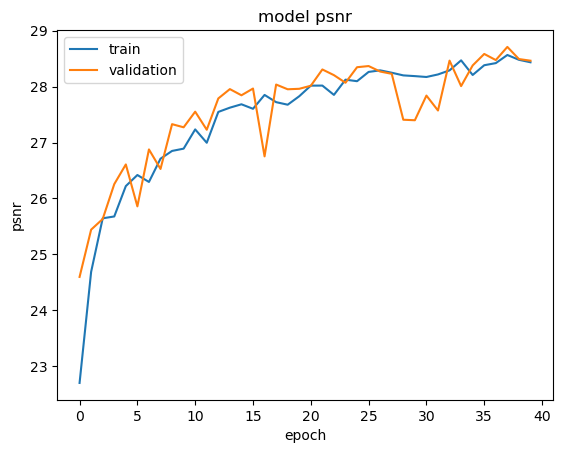

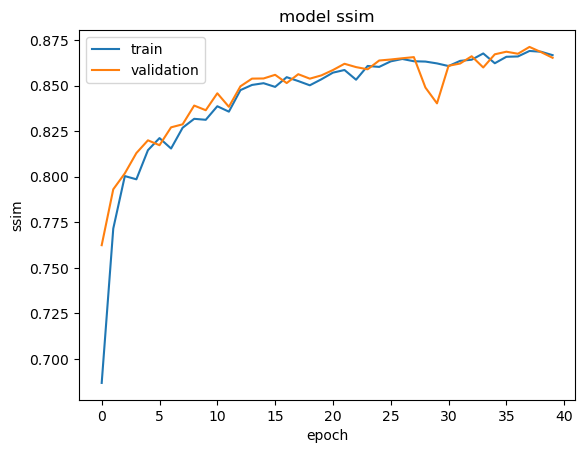

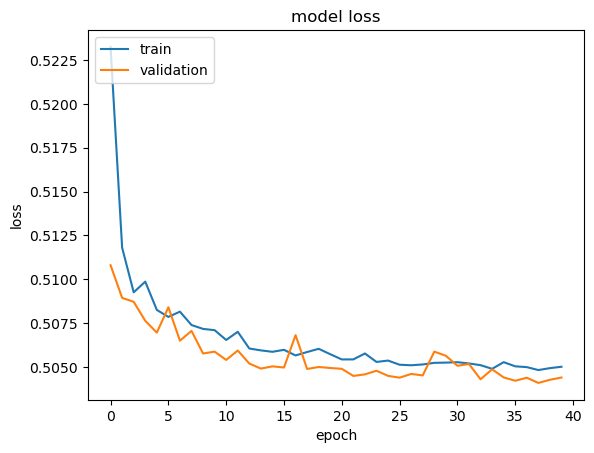

In [ ]:
# Configure the model for training.
# because our target data is integers.
dual_with_skip.compile(optimizer="adam", loss="binary_crossentropy", metrics=[psnr, ssim])

# Train the model, doing validation at the end of each epoch.
epochs = 40
history = dual_with_skip.fit(train_gen, epochs=epochs, validation_data=valid_gen)
visualization(history)

In [ ]:
dual_with_skip.save("dual_with_skip.h5")

312/312 [==============================] - 293s 940ms/step


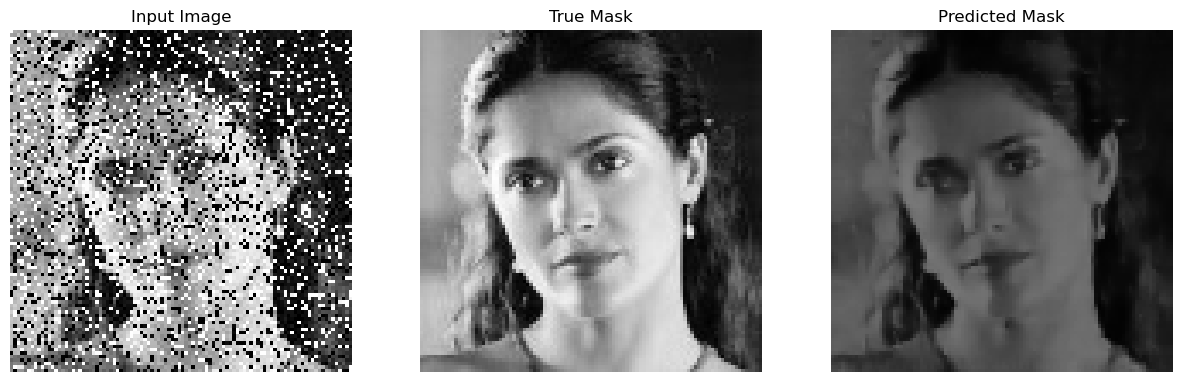

312/312 [==============================] - 71s 228ms/step


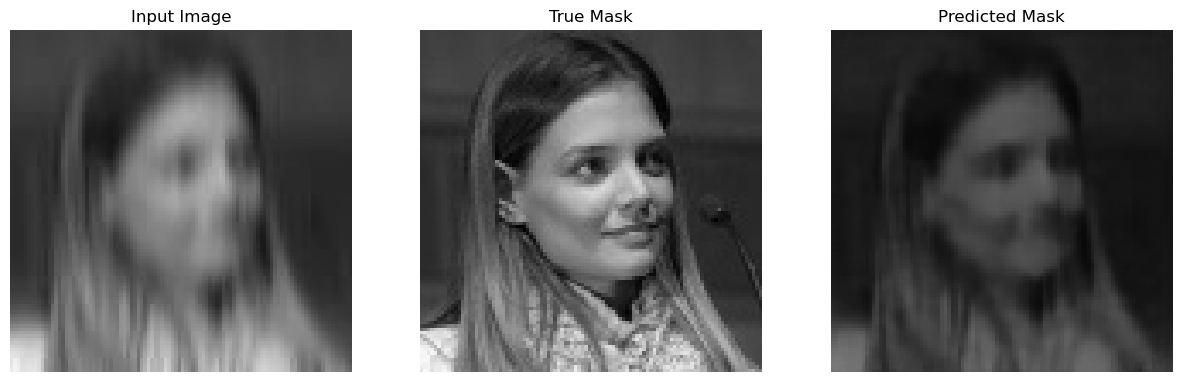

In [ ]:
display_result(dual_with_skip, 10)
display_result(dual_with_skip, 12)

In [ ]:
dual_sep_with_skip = dual_autoencoder_with_skip('SCNN')
dual_sep_with_skip.summary()

Model: "denoising"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 98, 98, 50)  109         ['image[0][0]']                  
 v2D)                                                                                             
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 48, 48, 35)  2235        ['separable_conv2d[0][0]']       
 onv2D)                                                                                   

Epoch 1/40
1125/1125 [==============================] - 318s 276ms/step - loss: 0.5633 - psnr: 19.6019 - ssim: 0.5443 - val_loss: 0.5184 - val_psnr: 22.2417 - val_ssim: 0.6619
Epoch 2/40
1125/1125 [==============================] - 317s 282ms/step - loss: 0.5179 - psnr: 22.5555 - ssim: 0.6704 - val_loss: 0.5169 - val_psnr: 22.7262 - val_ssim: 0.6763
Epoch 3/40
1125/1125 [==============================] - 308s 273ms/step - loss: 0.5159 - psnr: 23.1994 - ssim: 0.6963 - val_loss: 0.5154 - val_psnr: 23.2249 - val_ssim: 0.7040
Epoch 4/40
1125/1125 [==============================] - 311s 276ms/step - loss: 0.5138 - psnr: 23.9028 - ssim: 0.7254 - val_loss: 0.5125 - val_psnr: 24.1278 - val_ssim: 0.7263
Epoch 5/40
1125/1125 [==============================] - 330s 294ms/step - loss: 0.5123 - psnr: 24.4322 - ssim: 0.7429 - val_loss: 0.5110 - val_psnr: 24.7223 - val_ssim: 0.7491
Epoch 6/40
1125/1125 [==============================] - 378s 336ms/step - loss: 0.5116 - psnr: 24.7563 - ssim: 0.7522 - 

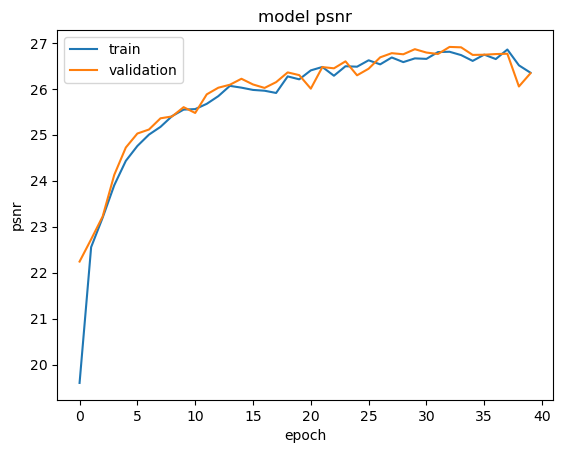

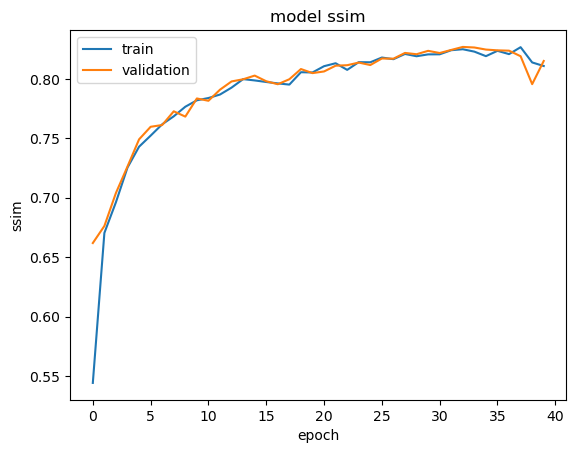

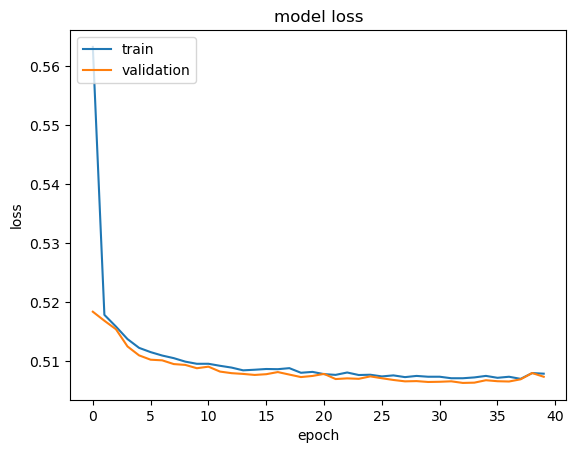

In [ ]:
# Configure the model for training.
# because our target data is integers.
dual_sep_with_skip.compile(optimizer="adam", loss="binary_crossentropy", metrics=[psnr, ssim])

# Train the model, doing validation at the end of each epoch.
epochs = 40
history = dual_sep_with_skip.fit(train_gen, epochs=epochs, validation_data=valid_gen)
visualization(history)

In [ ]:
dual_sep_with_skip.save("dual_sep_with_skip.h5")

312/312 [==============================] - 120s 384ms/step


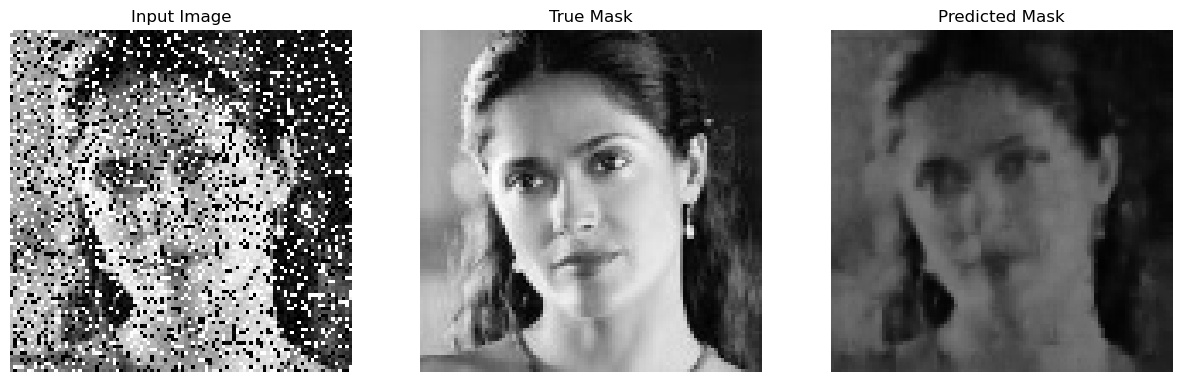

312/312 [==============================] - 88s 280ms/step


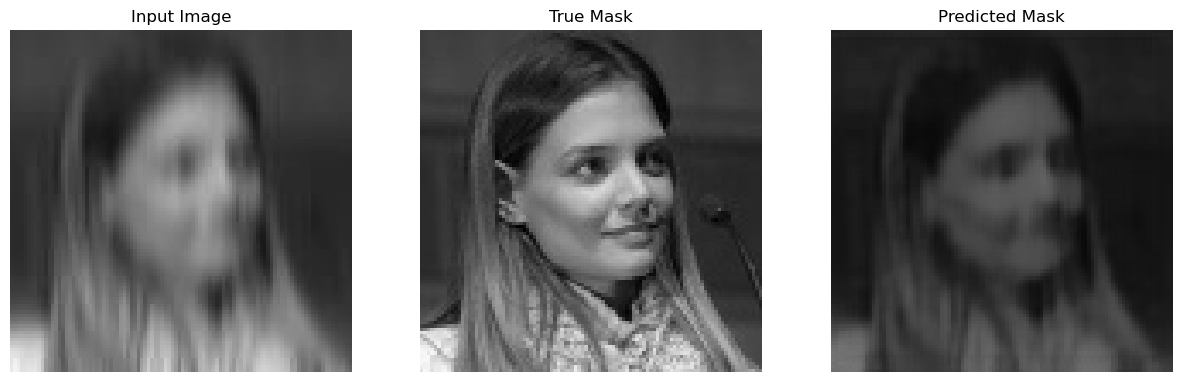

In [ ]:
display_result(dual_sep_with_skip, 10)
display_result(dual_sep_with_skip, 12)